# Toy Example - Parametric prior

In [2]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import elicit as el
import copy

from elicit.extras import utils

tfd = tfp.distributions

## The Model
### Generative model
\begin{align*}
    \beta_0 &\sim \text{Normal}(\mu_0, \sigma_0) \\
    \beta_1 &\sim \text{Normal}(\mu_1, \sigma_1) \\
    \sigma &\sim \text{HalfNormal}(\sigma_2) \\
    \mu &= \beta_0 + \beta_1X \\
    y_{pred} &\sim \text{Normal}(\mu, \sigma)
\end{align*}

### Implementation
#### Generative model

In [3]:
class ToyModel:
    def __call__(self, prior_samples, design_matrix):
        # linear predictor 
        epred=tf.matmul(prior_samples[:,:,:-1], design_matrix, 
                        transpose_b=True)
        
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        # selected observations
        y_X0, y_X1, y_X2 = (ypred[:,:,0], ypred[:,:,1], ypred[:,:,2])

        # R2 
        var_ypred = tf.math.reduce_variance(ypred, -1)
        var_epred = tf.math.reduce_variance(epred, -1)
        R2 = tf.math.divide(var_ypred, tf.add(var_ypred, var_epred))

        return dict(
            y_X0=y_X0, y_X1=y_X1, y_X2=y_X2,
            R2=R2
        )

#### Define design matrix

In [4]:
# create a predictor ranging from 1 to 200 
# standardize predictor
# select the 25th (X0), 50th (X1), and 75th (X2) quantile of the std. predictor for querying the expert
def X_design(N, quantiles):
    X = tf.cast(np.arange(N), tf.float32)
    X_std = (X-tf.reduce_mean(X))/tf.math.reduce_std(X)
    X_sel = tfp.stats.percentile(X_std, quantiles)
    X_design = tf.stack([tf.ones(X_sel.shape),X_sel], -1)
    return X_design
    
X_design(N=200, quantiles=[25,50,75])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.        , -0.85737586],
       [ 1.        ,  0.00866036],
       [ 1.        ,  0.85737586]], dtype=float32)>

#### Model input for elicit method

In [5]:
# specify the model
model=el.model(
        obj=ToyModel,
        design_matrix=X_design(N=200, quantiles=[25,50,75])
        )

### Model parameters
+ intercept with normal prior $\beta_0$
+ slope with normal prior $\beta_1$
+ random noise with halfnormal prior $\sigma$

**To be learned hyperparameters**
$
\lambda = (\mu_0, \sigma_0, \mu_1, \sigma_1, \sigma_2)
$

+ scale parameters ($\sigma_0, \sigma_1, \sigma_2$) are constrained to be positive

#### Parameter input for elicit method

In [6]:
parameters=[
        el.parameter(
            name="beta0",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu0"),
                scale=el.hyper("sigma0", lower=0)
                )
        ),
        el.parameter(
            name="beta1",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu1"),
                scale=el.hyper("sigma1", lower=0)
                )
        ),
        el.parameter(
            name="sigma",
            family=tfd.HalfNormal,
            hyperparams=dict(
                scale=el.hyper("sigma2", lower=0)
                )
        ),
    ]

## Target quantities and elicitation techniques
**Target quantities**
+ query expert regarding **prior predictions** $y \mid X_{i}$ with $i$ being the 25th, 50th, and 75th quantile of the predictor.

**Elicitation technique**
+ query each observation using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$

**Importance of elicited statistics in loss**
+ all elicited statistics should have equal importance (weight=1.0)
+ for computing the discrepancy between expert-elicited statistics and model simulations with use the Maximum Mean Discrepancy with Energy kernel

#### Targets input for elicit method

In [7]:
targets=[
    el.target(
        name="y_X0",
        query=el.queries.quantiles((.05, .25, .50, .75, .95)),
        loss=el.losses.MMD2(kernel="energy"),
        weight=1.0
    ),
    el.target(
        name="y_X1",
        query=el.queries.quantiles((.05, .25, .50, .75, .95)),
        loss=el.losses.MMD2(kernel="energy"),
        weight=1.0
    ),
    el.target(
        name="y_X2",
        query=el.queries.quantiles((.05, .25, .50, .75, .95)),
        loss=el.losses.MMD2(kernel="energy"),
        weight=1.0
    ),
    el.target(
        name="R2",
        query=el.queries.quantiles((.05, .25, .50, .75, .95)),
        loss=el.losses.MMD2(kernel="energy"),
        weight=1.0
    )
    ]

## Expert elicitation

+ instead of querying a "real" expert, we define a ground truth (i.e., oracle) and simulate the oracle-elicited statistics

#### Expert input for elicit method (here: oracle)

In [8]:
# specify ground truth
ground_truth = {
    "beta0": tfd.Normal(loc=5, scale=1),
    "beta1": tfd.Normal(loc=2, scale=2),
    "sigma": tfd.HalfNormal(scale=5.0),
}

# define oracle
expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    )

## Training: Learn prior distributions based on expert data

**All inputs for elicit method**

In [9]:
eliobj = el.Elicit(
    model=model,
    parameters=parameters,
    targets=targets,
    expert=expert,
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(0.1,400),
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="parametric_prior",
        seed=1,
        epochs=400
    ),
    initializer=el.initializer(
        method="random",
        loss_quantile=0,
        iterations=32,
        distribution=el.initialization.uniform(
            radius=3.,
            mean=3.
            )
        )
)

**Run multiple chains in parallel**

In [10]:
eliobj.fit(parallel=el.utils.parallel(chains=4))

**Save `eliobj`**

In [12]:
# save eliobj
eliobj.save(name="m1", overwrite=True)

saved in: ./results/parametric_prior/m1_1.pkl


## Results
### Initialization of hyperparameters

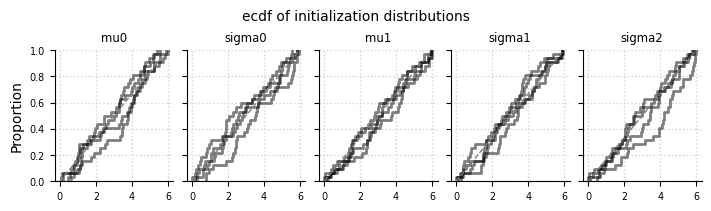

In [13]:
el.plots.initialization(eliobj, cols=5, figsize=(7,2))

### Convergence

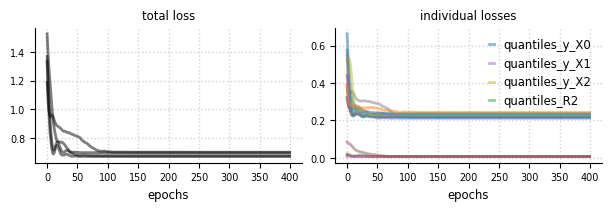

In [14]:
el.plots.loss(eliobj, figsize=(6,2))

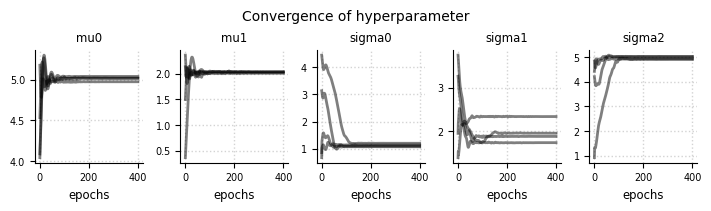

In [15]:
el.plots.hyperparameter(eliobj, cols=5, figsize=(7,2))

### Expert expectations

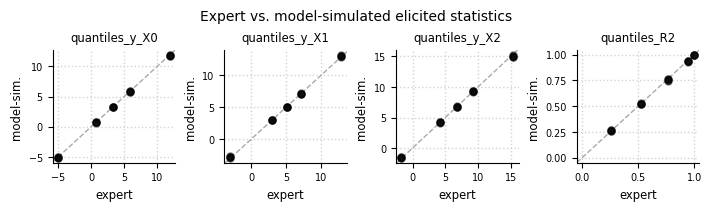

In [16]:
el.plots.elicits(eliobj, cols=4, figsize=(7,2))

### Learned priors
#### Joint prior

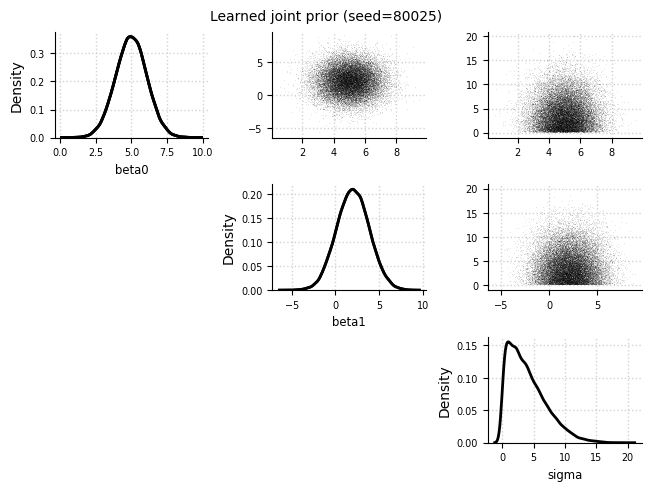

In [17]:
el.plots.prior_joint(eliobj, idx=0)

#### Marginal priors

INFO: Reset cols=3 (number of elicited statistics)


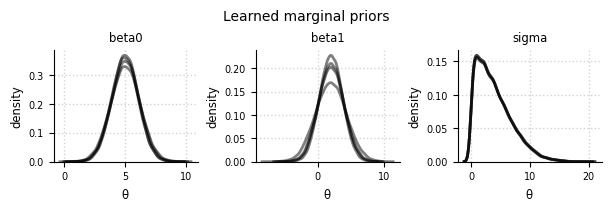

In [19]:
el.plots.prior_marginals(eliobj, figsize=(6,2))

### Model averaging

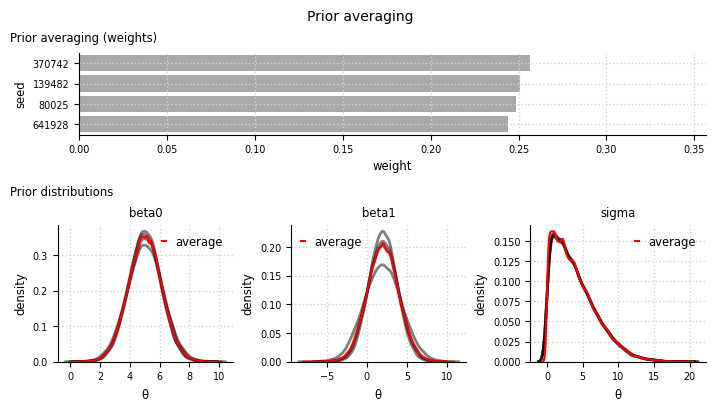

In [20]:
el.plots.prior_averaging(eliobj, cols=3, figsize=(7,4), height_ratio=[1,1.5])

## Add-on: Shared parameters

In [21]:
# create a copy of eliobj
eliobj_shared = copy.deepcopy(eliobj)

# share sigma hyperparameter of intercept and slope parameter 
parameters_shared=[
        el.parameter(
            name="beta0",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu0"),
                scale=el.hyper("sigma1", lower=0, shared=True)
                )
        ),
        el.parameter(
            name="beta1",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu1"),
                scale=el.hyper("sigma1", lower=0, shared=True)
                )
        ),
        el.parameter(
            name="sigma",
            family=tfd.HalfNormal,
            hyperparams=dict(
                scale=el.hyper("sigma2", lower=0)
                )
        ),
    ]

# update parameters in eliobj
eliobj_shared.update(parameters=parameters_shared)

# refit the model (run only once)
eliobj_shared.fit()

INFO: Results have been reset.
Initialization


100%|██████████| 32/32 [00:04<00:00,  6.44it/s]


 
Training


100%|██████████| 400/400 [02:14<00:00,  2.97it/s]


### Results
#### Initialization of hyperparameters

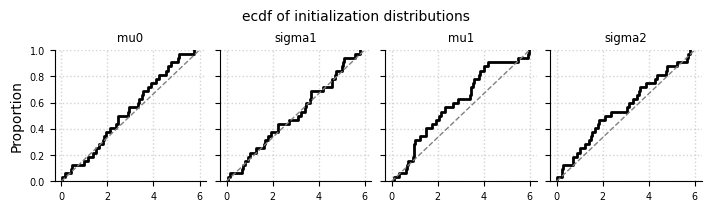

In [22]:
el.plots.initialization(eliobj_shared, cols=4, figsize=(7,2))

#### Convergence

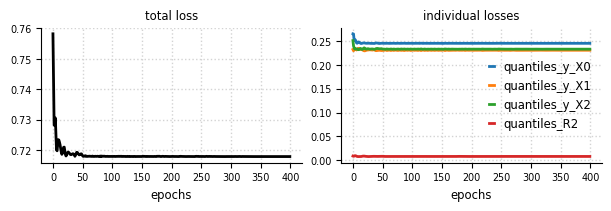

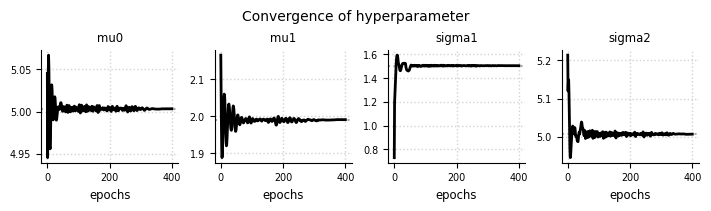

In [23]:
el.plots.loss(eliobj_shared, figsize=(6,2))
el.plots.hyperparameter(eliobj_shared, figsize=(7,2))

#### Expert expectations

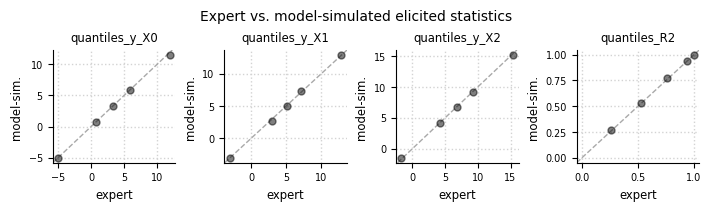

In [24]:
el.plots.elicits(eliobj_shared, cols=4, figsize=(7,2))

#### Learned priors

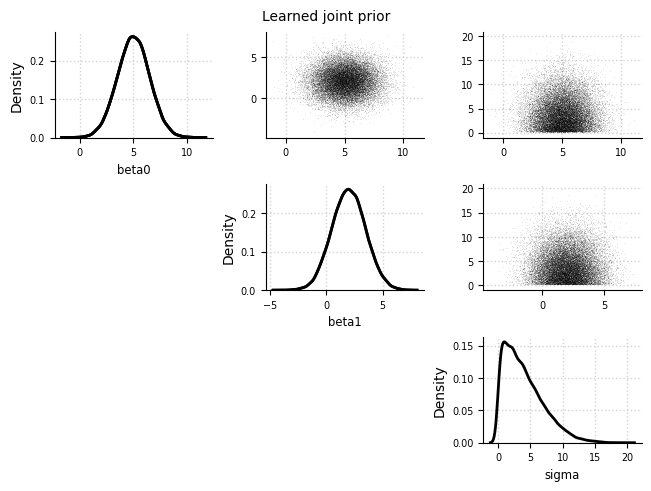

In [25]:
el.plots.prior_joint(eliobj_shared)

## Add-on: Use expert data as input

In [35]:
# create a copy of eliobj
eliobj_dat = copy.deepcopy(eliobj)

# use dictionary of elicited expert data (instead of simulating data)
expert_dat = {
    "quantiles_y_X0": [-5.0, 0.7, 3.3, 5.9, 11.9],
    "quantiles_y_X1": [-3.1, 3.0, 5.0, 7.1, 12.9],
    "quantiles_y_X2": [-1.7, 4.2, 6.8, 9.3, 15.4],
    "quantiles_R2": [0.26, 0.53, 0.76, 0.94, 0.99]
}

# update expert in eliobj
eliobj_dat.update(expert=el.expert.data(dat = expert_dat))

# refit the model and run again once
eliobj_dat.fit()

INFO: Results have been reset.
Initialization


100%|██████████| 32/32 [00:04<00:00,  7.91it/s]


 
Training


100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


### Results
#### Initialization of hyperparameters

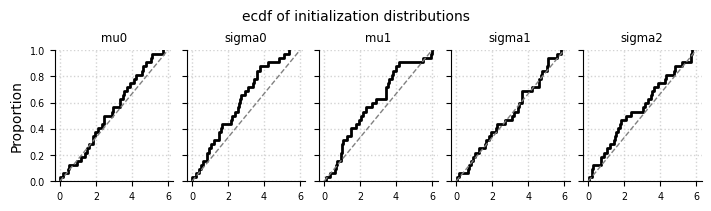

In [30]:
el.plots.initialization(eliobj_dat, cols=5, figsize=(7,2))

#### Convergence

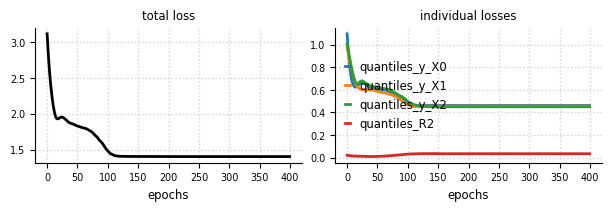

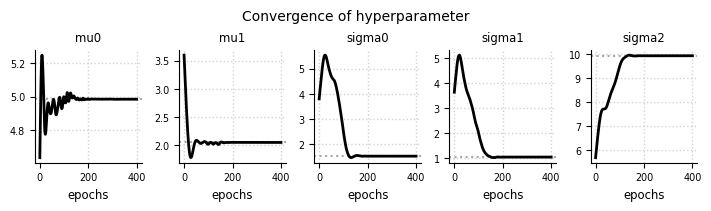

In [31]:
el.plots.loss(eliobj_dat, figsize=(6,2))
el.plots.hyperparameter(eliobj_dat, cols=5, figsize=(7,2))

#### Expert expectations

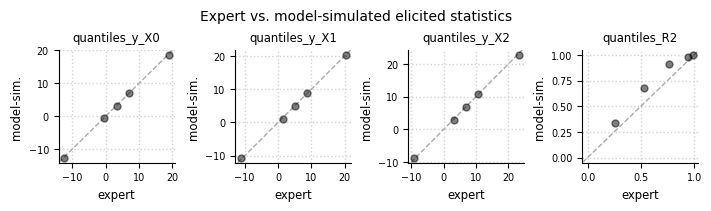

In [32]:
el.plots.elicits(eliobj_dat, cols=4, figsize=(7,2))

#### Learned priors

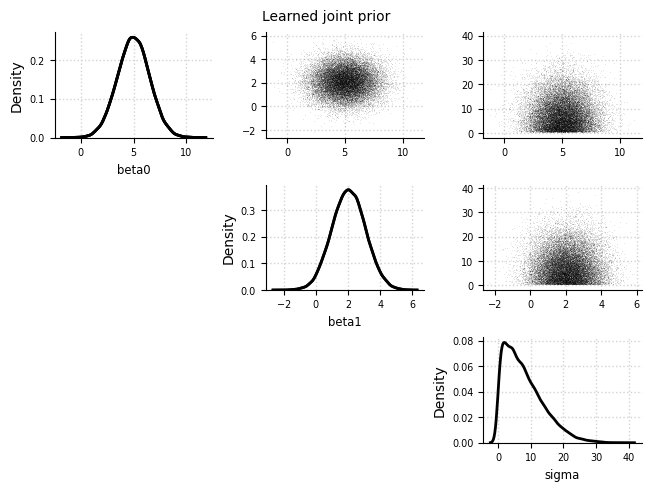

In [33]:
el.plots.prior_joint(eliobj_dat)